### Reading data

In [1]:
#%matplotlib notebook
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sn
import pandas as pd
from collections import Counter
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"
pd.set_option('display.precision', 3)

C:\Users\Santiago\anaconda3\Lib\site-packages\pandas\core\arrays\masked.py:60: UserWarning: Pandas requires version '1.3.6' or newer of 'bottleneck' (version '1.3.5' currently installed).
  from pandas.core import (


In [2]:
# Extra imports
from pandas import read_csv
from sklearn.neighbors import KNeighborsClassifier
from sklearn.neighbors import KNeighborsRegressor
from sklearn.neighbors import LocalOutlierFactor
from sklearn.metrics import mean_squared_error
from sklearn import preprocessing
from sklearn.preprocessing import PolynomialFeatures
from pandas.plotting import scatter_matrix
from scipy.stats import boxcox
from statsmodels.genmod.generalized_linear_model import GLM

In [3]:
# Extra imports
from pandas import read_csv
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.tree import DecisionTreeRegressor
import graphviz

from sklearn.tree import export_graphviz
from sklearn.ensemble import RandomForestRegressor, VotingRegressor, ExtraTreesRegressor
from imblearn.under_sampling import RandomUnderSampler
from sklearn.model_selection import GridSearchCV, KFold

from time import time
from datetime import timedelta

import seaborn as sns
from matplotlib import pyplot as plt

from sklearn.model_selection import GridSearchCV
from sklearn.metrics import make_scorer
 
from sklearn.linear_model import LinearRegression, Ridge, RidgeCV, Lasso, LassoCV
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.preprocessing import MinMaxScaler

from statsmodels.genmod.generalized_linear_model import GLM
import statsmodels.api as sm
from scipy import stats

import random

In [4]:
#code is reproducible 
random.seed(7)
np.random.seed(42)

### Read Dataset

In [5]:
from scipy.io import arff
arff_file = arff.loadarff('dataset_miami.arff')
df= pd.DataFrame(arff_file[0])
df.head()

,LATITUDE,LONGITUDE,PARCELNO,SALE_PRC,LND_SQFOOT,TOT_LVG_AREA,SPEC_FEAT_VAL,RAIL_DIST,OCEAN_DIST,WATER_DIST,CNTR_DIST,SUBCNTR_DI,HWY_DIST,age,avno60plus,month_sold,structure_quality
0,25.891,-80.161,3.074e-312,440000.0,9375.0,1753.0,0.0,2815.9,12811.4,347.6,42815.3,37742.2,15954.9,67.0,0.0,8.0,4.0
1,25.891,-80.154,3.074e-312,349000.0,9375.0,1715.0,0.0,4359.1,10648.4,337.8,43504.9,37340.5,18125.0,63.0,0.0,9.0,4.0
2,25.891,-80.154,3.074e-312,800000.0,9375.0,2276.0,49206.0,4412.9,10574.1,297.1,43530.4,37328.7,18200.5,61.0,0.0,2.0,4.0
3,25.892,-80.153,3.074e-312,988000.0,12450.0,2058.0,10033.0,4585.0,10156.5,0.0,43797.5,37423.2,18514.4,63.0,0.0,9.0,4.0
4,25.892,-80.155,3.074e-312,755000.0,12800.0,1684.0,16681.0,4063.4,10836.8,326.6,43599.7,37550.8,17903.4,42.0,0.0,7.0,4.0


In [6]:
#### Set all column names to capital letters
df.columns = df.columns.str.upper()
#### Eliminate PARECLNO as it is just an identifier and I won't need it to predict sale price.
df = df.drop('PARCELNO', axis=1)

#### Eliminate Latitude and Longitude as their infuence is really hard to compute
df = df.drop('LATITUDE', axis=1)
df = df.drop('LONGITUDE', axis=1)

In [7]:
#### We would like all variables to be discrete as it is easier to deal with. 
#### We'll be losing some information so if I came up with a better way to deal with this problem I'll update it

# Convert selected columns to int64
df = df.astype('int64')
df.dtypes

SALE_PRC             int64
LND_SQFOOT           int64
TOT_LVG_AREA         int64
SPEC_FEAT_VAL        int64
RAIL_DIST            int64
OCEAN_DIST           int64
WATER_DIST           int64
CNTR_DIST            int64
SUBCNTR_DI           int64
HWY_DIST             int64
AGE                  int64
AVNO60PLUS           int64
MONTH_SOLD           int64
STRUCTURE_QUALITY    int64
dtype: object

In [8]:
df.head()

,SALE_PRC,LND_SQFOOT,TOT_LVG_AREA,SPEC_FEAT_VAL,RAIL_DIST,OCEAN_DIST,WATER_DIST,CNTR_DIST,SUBCNTR_DI,HWY_DIST,AGE,AVNO60PLUS,MONTH_SOLD,STRUCTURE_QUALITY
0,440000,9375,1753,0,2815,12811,347,42815,37742,15954,67,0,8,4
1,349000,9375,1715,0,4359,10648,337,43504,37340,18125,63,0,9,4
2,800000,9375,2276,49206,4412,10574,297,43530,37328,18200,61,0,2,4
3,988000,12450,2058,10033,4585,10156,0,43797,37423,18514,63,0,9,4
4,755000,12800,1684,16681,4063,10836,326,43599,37550,17903,42,0,7,4


In [9]:
df.shape

(13932, 14)

## Preprocessing

### INSPECTION OF THE DATASET

In [10]:
df.describe()

,SALE_PRC,LND_SQFOOT,TOT_LVG_AREA,SPEC_FEAT_VAL,RAIL_DIST,OCEAN_DIST,WATER_DIST,CNTR_DIST,SUBCNTR_DI,HWY_DIST,AGE,AVNO60PLUS,MONTH_SOLD,STRUCTURE_QUALITY
count,1.393e+04,13932.000,13932.000,13932.000,13932.000,13932.000,13932.000,13932.000,13932.000,13932.000,13932.000,13932.000,13932.000,13932.000
mean,3.999e+05,8620.880,2058.045,9562.493,8348.100,31690.548,11959.837,68489.879,41114.596,7723.320,30.669,0.015,6.656,3.514
std,3.172e+05,6070.089,813.539,13890.968,6178.029,17595.078,11932.985,32008.471,22161.821,6068.939,21.153,0.121,3.302,1.097
min,7.200e+04,1248.000,854.000,0.000,10.000,236.000,0.000,3825.000,1462.000,90.000,0.000,0.000,1.000,1.000
25%,2.350e+05,5400.000,1470.000,810.000,3299.000,18079.250,2675.750,42822.500,23995.750,2997.750,14.000,0.000,4.000,2.000
50%,3.100e+05,7500.000,1877.500,2765.500,7105.500,28541.500,6922.000,65852.000,41109.500,6159.000,26.000,0.000,7.000,4.000
75%,4.280e+05,9126.250,2471.000,12352.250,12102.000,44309.750,19199.750,89357.750,53949.000,10853.500,46.000,0.000,9.000,4.000
max,2.650e+06,57064.000,6287.000,175020.000,29621.000,75744.000,50399.000,159976.000,110553.000,48167.000,96.000,1.000,12.000,5.000


In [11]:
print(df['SALE_PRC'].value_counts())
print(df['LND_SQFOOT'].value_counts())
print(df['TOT_LVG_AREA'].value_counts())
print(df['SPEC_FEAT_VAL'].value_counts())
print(df['RAIL_DIST'].value_counts())
print(df['OCEAN_DIST'].value_counts())
print(df['WATER_DIST'].value_counts())
print(df['CNTR_DIST'].value_counts())
print(df['SUBCNTR_DI'].value_counts())
print(df['HWY_DIST'].value_counts())
print(df['AGE'].value_counts())
print(df['AVNO60PLUS'].value_counts())
print(df['MONTH_SOLD'].value_counts())
print(df['STRUCTURE_QUALITY'].value_counts())


SALE_PRC
250000     196
300000     193
260000     163
270000     163
280000     152
          ... 
543000       1
1137000      1
1228000      1
586500       1
233500       1
Name: count, Length: 2111, dtype: int64
LND_SQFOOT
7500     1021
5000      627
6000      312
7875      187
8250      136
         ... 
14530       1
7933        1
7533        1
7949        1
8833        1
Name: count, Length: 4696, dtype: int64
TOT_LVG_AREA
3079    29
3199    27
1440    24
2176    22
1701    22
        ..
3905     1
4950     1
3485     1
6137     1
2602     1
Name: count, Length: 2978, dtype: int64
SPEC_FEAT_VAL
0        2290
550        45
440        27
4800       23
1200       22
         ... 
28773       1
6805        1
28668       1
34400       1
6580        1
Name: count, Length: 7583, dtype: int64
RAIL_DIST
49       15
50       10
699       7
2937      7
6558      6
         ..
10727     1
10859     1
13726     1
9095      1
4143      1
Name: count, Length: 9747, dtype: int64
OCEAN_DIST
55025 

In [12]:
df_copy = df.copy()

### DEALING WITH MISSING VALUES

In [13]:
#### I don't observe any abnormal values that could be understood as a missing values so
#### I'll introduce some missing values at random in columns ocean distance, cntr_dist and strcuture quality 
#### in order to do some preprocessing. I'll do a missing proportion of 1%
columns_with_missing = ['OCEAN_DIST', 'CNTR_DIST', 'STRUCTURE_QUALITY']

missing_percentage = 0.01

for col in columns_with_missing:
    num_missing = int(len(df[col]) * missing_percentage)
    missing_indices = np.random.choice(df.index, size=num_missing, replace=True)
    df.loc[missing_indices, col] = np.nan

In [14]:
#### For the numerical variables, discarding isn't good as we'd lose information from the other columns. 
#### Imputing the missing values is better (infer them from the known part of the data).

df.STRUCTURE_QUALITY.isna().value_counts()
df.OCEAN_DIST.isna().value_counts()
df.CNTR_DIST.isna().value_counts()

STRUCTURE_QUALITY
False    13794
True       138
Name: count, dtype: int64

OCEAN_DIST
False    13793
True       139
Name: count, dtype: int64

CNTR_DIST
False    13794
True       138
Name: count, dtype: int64

In [15]:
#### To imput the missing values we will aply KNN:
subset = df.drop(columns=['OCEAN_DIST', 'CNTR_DIST', 'STRUCTURE_QUALITY'])
subset.shape
subset.head()
df.dtypes

rows_not_missing = df.OCEAN_DIST.notna() & df.CNTR_DIST.notna() & df.STRUCTURE_QUALITY.notna()

df_without_missings = subset[rows_not_missing]
df_without_missings.shape

(13932, 11)

,SALE_PRC,LND_SQFOOT,TOT_LVG_AREA,SPEC_FEAT_VAL,RAIL_DIST,WATER_DIST,SUBCNTR_DI,HWY_DIST,AGE,AVNO60PLUS,MONTH_SOLD
0,440000,9375,1753,0,2815,347,37742,15954,67,0,8
1,349000,9375,1715,0,4359,337,37340,18125,63,0,9
2,800000,9375,2276,49206,4412,297,37328,18200,61,0,2
3,988000,12450,2058,10033,4585,0,37423,18514,63,0,9
4,755000,12800,1684,16681,4063,326,37550,17903,42,0,7


SALE_PRC               int64
LND_SQFOOT             int64
TOT_LVG_AREA           int64
SPEC_FEAT_VAL          int64
RAIL_DIST              int64
OCEAN_DIST           float64
WATER_DIST             int64
CNTR_DIST            float64
SUBCNTR_DI             int64
HWY_DIST               int64
AGE                    int64
AVNO60PLUS             int64
MONTH_SOLD             int64
STRUCTURE_QUALITY    float64
dtype: object

(13523, 11)

In [16]:
#### In the case of the variable STRUCTURE_QUALITY, as it is a cathegorical variable, 
### I will perform K-NN classification

structure_missing_values = subset[df.STRUCTURE_QUALITY.isna()]

knn = KNeighborsClassifier(n_neighbors=1)
knn.fit(df_without_missings, df.STRUCTURE_QUALITY[rows_not_missing])
knn_structure = knn.predict(structure_missing_values)

KNeighborsClassifier(n_neighbors=1)

In [17]:
### As Ocean_distance and Cntr_dist are numerical, I can't use K-NN classification, so I'll do K-NN regression

In [18]:
#### Imputation of Ocean_distance:
ocean_missing_values = subset[df.OCEAN_DIST.isna()]

knn = KNeighborsRegressor(n_neighbors=1)
knn.fit(df_without_missings, df.OCEAN_DIST[rows_not_missing])
knn_ocean = knn.predict(ocean_missing_values)

KNeighborsRegressor(n_neighbors=1)

In [19]:
#### Imputation of CNTR_DIST:
cntr_dist_missing_values = subset[df.CNTR_DIST.isna()]

knn = KNeighborsClassifier(n_neighbors=1)
knn.fit(df_without_missings, df.CNTR_DIST[rows_not_missing])
knn_cntr_dist = knn.predict(cntr_dist_missing_values)

KNeighborsClassifier(n_neighbors=1)

In [20]:
#### Update the data frame:
df.STRUCTURE_QUALITY[df.STRUCTURE_QUALITY.isna()] = knn_structure
df.OCEAN_DIST[df.OCEAN_DIST.isna()] = knn_ocean
df.CNTR_DIST[df.CNTR_DIST.isna()] = knn_cntr_dist

C:\Users\Santiago\AppData\Local\Temp\ipykernel_12828\3324226579.py:2: FutureWarning: ChainedAssignmentError: behaviour will change in pandas 3.0!
You are setting values through chained assignment. Currently this works in certain cases, but when using Copy-on-Write (which will become the default behaviour in pandas 3.0) this will never work to update the original DataFrame or Series, because the intermediate object on which we are setting values will behave as a copy.
A typical example is when you are setting values in a column of a DataFrame, like:

df["col"][row_indexer] = value

Use `df.loc[row_indexer, "col"] = values` instead, to perform the assignment in a single step and ensure this keeps updating the original `df`.

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

  df.STRUCTURE_QUALITY[df.STRUCTURE_QUALITY.isna()] = knn_structure
C:\Users\Santiago\AppData\Local\Temp\ipykernel_12828\332422

In [21]:
df.describe()
df_copy.describe()

,SALE_PRC,LND_SQFOOT,TOT_LVG_AREA,SPEC_FEAT_VAL,RAIL_DIST,OCEAN_DIST,WATER_DIST,CNTR_DIST,SUBCNTR_DI,HWY_DIST,AGE,AVNO60PLUS,MONTH_SOLD,STRUCTURE_QUALITY
count,1.393e+04,13932.000,13932.000,13932.000,13932.000,13932.000,13932.000,13932.000,13932.000,13932.000,13932.000,13932.000,13932.000,13932.000
mean,3.999e+05,8620.880,2058.045,9562.493,8348.100,31685.715,11959.837,68496.619,41114.596,7723.320,30.669,0.015,6.656,3.515
std,3.172e+05,6070.089,813.539,13890.968,6178.029,17583.666,11932.985,32000.577,22161.821,6068.939,21.153,0.121,3.302,1.097
min,7.200e+04,1248.000,854.000,0.000,10.000,236.000,0.000,3825.000,1462.000,90.000,0.000,0.000,1.000,1.000
25%,2.350e+05,5400.000,1470.000,810.000,3299.000,18096.750,2675.750,42848.500,23995.750,2997.750,14.000,0.000,4.000,2.000
50%,3.100e+05,7500.000,1877.500,2765.500,7105.500,28545.000,6922.000,65854.000,41109.500,6159.000,26.000,0.000,7.000,4.000
75%,4.280e+05,9126.250,2471.000,12352.250,12102.000,44298.000,19199.750,89345.750,53949.000,10853.500,46.000,0.000,9.000,4.000
max,2.650e+06,57064.000,6287.000,175020.000,29621.000,75744.000,50399.000,159976.000,110553.000,48167.000,96.000,1.000,12.000,5.000


,SALE_PRC,LND_SQFOOT,TOT_LVG_AREA,SPEC_FEAT_VAL,RAIL_DIST,OCEAN_DIST,WATER_DIST,CNTR_DIST,SUBCNTR_DI,HWY_DIST,AGE,AVNO60PLUS,MONTH_SOLD,STRUCTURE_QUALITY
count,1.393e+04,13932.000,13932.000,13932.000,13932.000,13932.000,13932.000,13932.000,13932.000,13932.000,13932.000,13932.000,13932.000,13932.000
mean,3.999e+05,8620.880,2058.045,9562.493,8348.100,31690.548,11959.837,68489.879,41114.596,7723.320,30.669,0.015,6.656,3.514
std,3.172e+05,6070.089,813.539,13890.968,6178.029,17595.078,11932.985,32008.471,22161.821,6068.939,21.153,0.121,3.302,1.097
min,7.200e+04,1248.000,854.000,0.000,10.000,236.000,0.000,3825.000,1462.000,90.000,0.000,0.000,1.000,1.000
25%,2.350e+05,5400.000,1470.000,810.000,3299.000,18079.250,2675.750,42822.500,23995.750,2997.750,14.000,0.000,4.000,2.000
50%,3.100e+05,7500.000,1877.500,2765.500,7105.500,28541.500,6922.000,65852.000,41109.500,6159.000,26.000,0.000,7.000,4.000
75%,4.280e+05,9126.250,2471.000,12352.250,12102.000,44309.750,19199.750,89357.750,53949.000,10853.500,46.000,0.000,9.000,4.000
max,2.650e+06,57064.000,6287.000,175020.000,29621.000,75744.000,50399.000,159976.000,110553.000,48167.000,96.000,1.000,12.000,5.000


Text(0.5, 1.0, 'STRUCTURE_QUALITY: Original vs Imputed')

Text(0.5, 0, 'Original')

Text(0, 0.5, 'Imputed')

Text(0.5, 1.0, 'OCEAN_DIST: Original vs Imputed')

Text(0.5, 0, 'Original')

Text(0, 0.5, 'Imputed')

Text(0.5, 1.0, 'CNTR_DIST: Original vs Imputed')

Text(0.5, 0, 'Original')

Text(0, 0.5, 'Imputed')

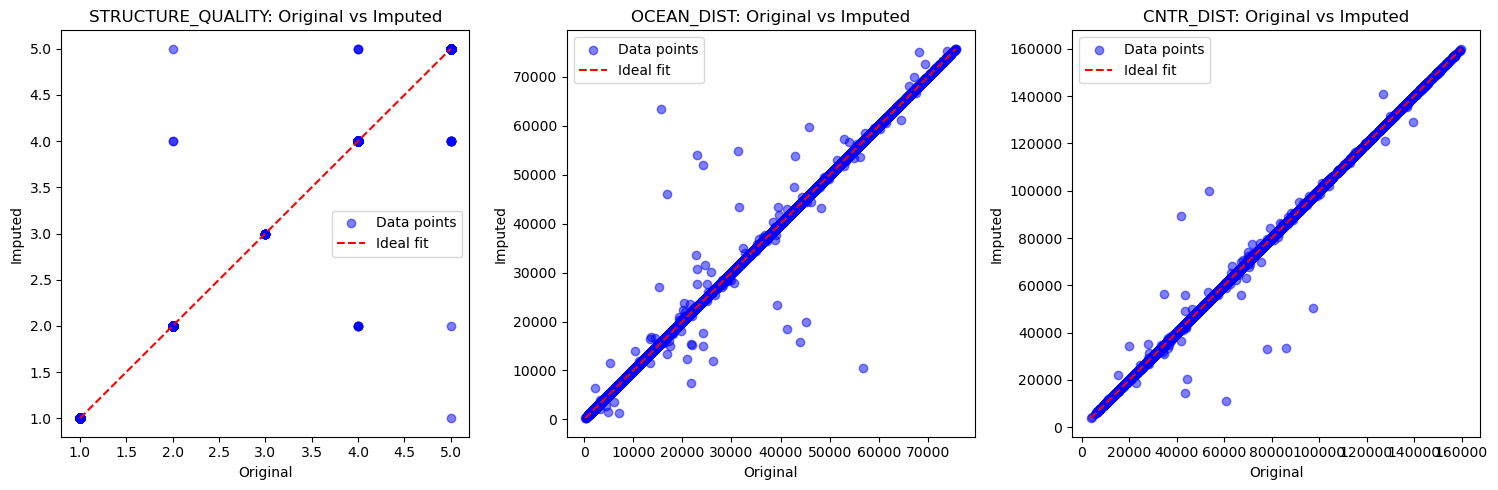

In [22]:
columns_modified = ['STRUCTURE_QUALITY', 'OCEAN_DIST', 'CNTR_DIST']

fig, axes = plt.subplots(nrows=1, ncols=3, figsize=(15, 5))

for i, column in enumerate(columns_modified):
    ax = axes[i]
    
    # Plot the original vs imputed values
    ax.scatter(df[column], df_copy[column], alpha=0.5, c='blue', label='Data points')
    ax.plot([df[column].min(), df[column].max()], [df[column].min(), df[column].max()], 'r--', label='Ideal fit')
    
    ax.set_title(f'{column}: Original vs Imputed')
    ax.set_xlabel('Original')
    ax.set_ylabel('Imputed')
    ax.legend()

plt.tight_layout()
plt.show()

In [23]:
#### We don't observe significant differences between variables before and after the outlier treatment, so the imputation is well done

### DETECTING OUTLIERS

Counter for LND_SQFOOT: Counter({1: 12113, -1: 1819})


<Axes: xlabel='LND_SQFOOT'>

Text(0.5, 1.0, 'Boxplot of LND_SQFOOT (Inliers)')

Text(0.5, 0, 'LND_SQFOOT')

<Axes: xlabel='LND_SQFOOT', ylabel='Count'>

Text(0.5, 1.0, 'Histogram of LND_SQFOOT (Inliers)')

Text(0.5, 0, 'LND_SQFOOT')

Text(0, 0.5, 'Frequency')

Counter for TOT_LVG_AREA: Counter({1: 13910, -1: 22})


<Axes: xlabel='TOT_LVG_AREA'>

Text(0.5, 1.0, 'Boxplot of TOT_LVG_AREA (Inliers)')

Text(0.5, 0, 'TOT_LVG_AREA')

<Axes: xlabel='TOT_LVG_AREA', ylabel='Count'>

Text(0.5, 1.0, 'Histogram of TOT_LVG_AREA (Inliers)')

Text(0.5, 0, 'TOT_LVG_AREA')

Text(0, 0.5, 'Frequency')

Counter for SPEC_FEAT_VAL: Counter({1: 13857, -1: 75})


<Axes: xlabel='SPEC_FEAT_VAL'>

Text(0.5, 1.0, 'Boxplot of SPEC_FEAT_VAL (Inliers)')

Text(0.5, 0, 'SPEC_FEAT_VAL')

<Axes: xlabel='SPEC_FEAT_VAL', ylabel='Count'>

Text(0.5, 1.0, 'Histogram of SPEC_FEAT_VAL (Inliers)')

Text(0.5, 0, 'SPEC_FEAT_VAL')

Text(0, 0.5, 'Frequency')

Counter for RAIL_DIST: Counter({1: 13924, -1: 8})


<Axes: xlabel='RAIL_DIST'>

Text(0.5, 1.0, 'Boxplot of RAIL_DIST (Inliers)')

Text(0.5, 0, 'RAIL_DIST')

<Axes: xlabel='RAIL_DIST', ylabel='Count'>

Text(0.5, 1.0, 'Histogram of RAIL_DIST (Inliers)')

Text(0.5, 0, 'RAIL_DIST')

Text(0, 0.5, 'Frequency')

Counter for OCEAN_DIST: Counter({1: 13911, -1: 21})


<Axes: xlabel='OCEAN_DIST'>

Text(0.5, 1.0, 'Boxplot of OCEAN_DIST (Inliers)')

Text(0.5, 0, 'OCEAN_DIST')

<Axes: xlabel='OCEAN_DIST', ylabel='Count'>

Text(0.5, 1.0, 'Histogram of OCEAN_DIST (Inliers)')

Text(0.5, 0, 'OCEAN_DIST')

Text(0, 0.5, 'Frequency')

Counter for WATER_DIST: Counter({1: 13840, -1: 92})


<Axes: xlabel='WATER_DIST'>

Text(0.5, 1.0, 'Boxplot of WATER_DIST (Inliers)')

Text(0.5, 0, 'WATER_DIST')

<Axes: xlabel='WATER_DIST', ylabel='Count'>

Text(0.5, 1.0, 'Histogram of WATER_DIST (Inliers)')

Text(0.5, 0, 'WATER_DIST')

Text(0, 0.5, 'Frequency')

Counter for CNTR_DIST: Counter({1: 13875, -1: 57})


<Axes: xlabel='CNTR_DIST'>

Text(0.5, 1.0, 'Boxplot of CNTR_DIST (Inliers)')

Text(0.5, 0, 'CNTR_DIST')

<Axes: xlabel='CNTR_DIST', ylabel='Count'>

Text(0.5, 1.0, 'Histogram of CNTR_DIST (Inliers)')

Text(0.5, 0, 'CNTR_DIST')

Text(0, 0.5, 'Frequency')

Counter for SUBCNTR_DI: Counter({1: 13912, -1: 20})


<Axes: xlabel='SUBCNTR_DI'>

Text(0.5, 1.0, 'Boxplot of SUBCNTR_DI (Inliers)')

Text(0.5, 0, 'SUBCNTR_DI')

<Axes: xlabel='SUBCNTR_DI', ylabel='Count'>

Text(0.5, 1.0, 'Histogram of SUBCNTR_DI (Inliers)')

Text(0.5, 0, 'SUBCNTR_DI')

Text(0, 0.5, 'Frequency')

Counter for HWY_DIST: Counter({1: 13873, -1: 59})


<Axes: xlabel='HWY_DIST'>

Text(0.5, 1.0, 'Boxplot of HWY_DIST (Inliers)')

Text(0.5, 0, 'HWY_DIST')

<Axes: xlabel='HWY_DIST', ylabel='Count'>

Text(0.5, 1.0, 'Histogram of HWY_DIST (Inliers)')

Text(0.5, 0, 'HWY_DIST')

Text(0, 0.5, 'Frequency')

Counter for AGE: Counter({1: 13881, -1: 51})


<Axes: xlabel='AGE'>

Text(0.5, 1.0, 'Boxplot of AGE (Inliers)')

Text(0.5, 0, 'AGE')

<Axes: xlabel='AGE', ylabel='Count'>

Text(0.5, 1.0, 'Histogram of AGE (Inliers)')

Text(0.5, 0, 'AGE')

Text(0, 0.5, 'Frequency')

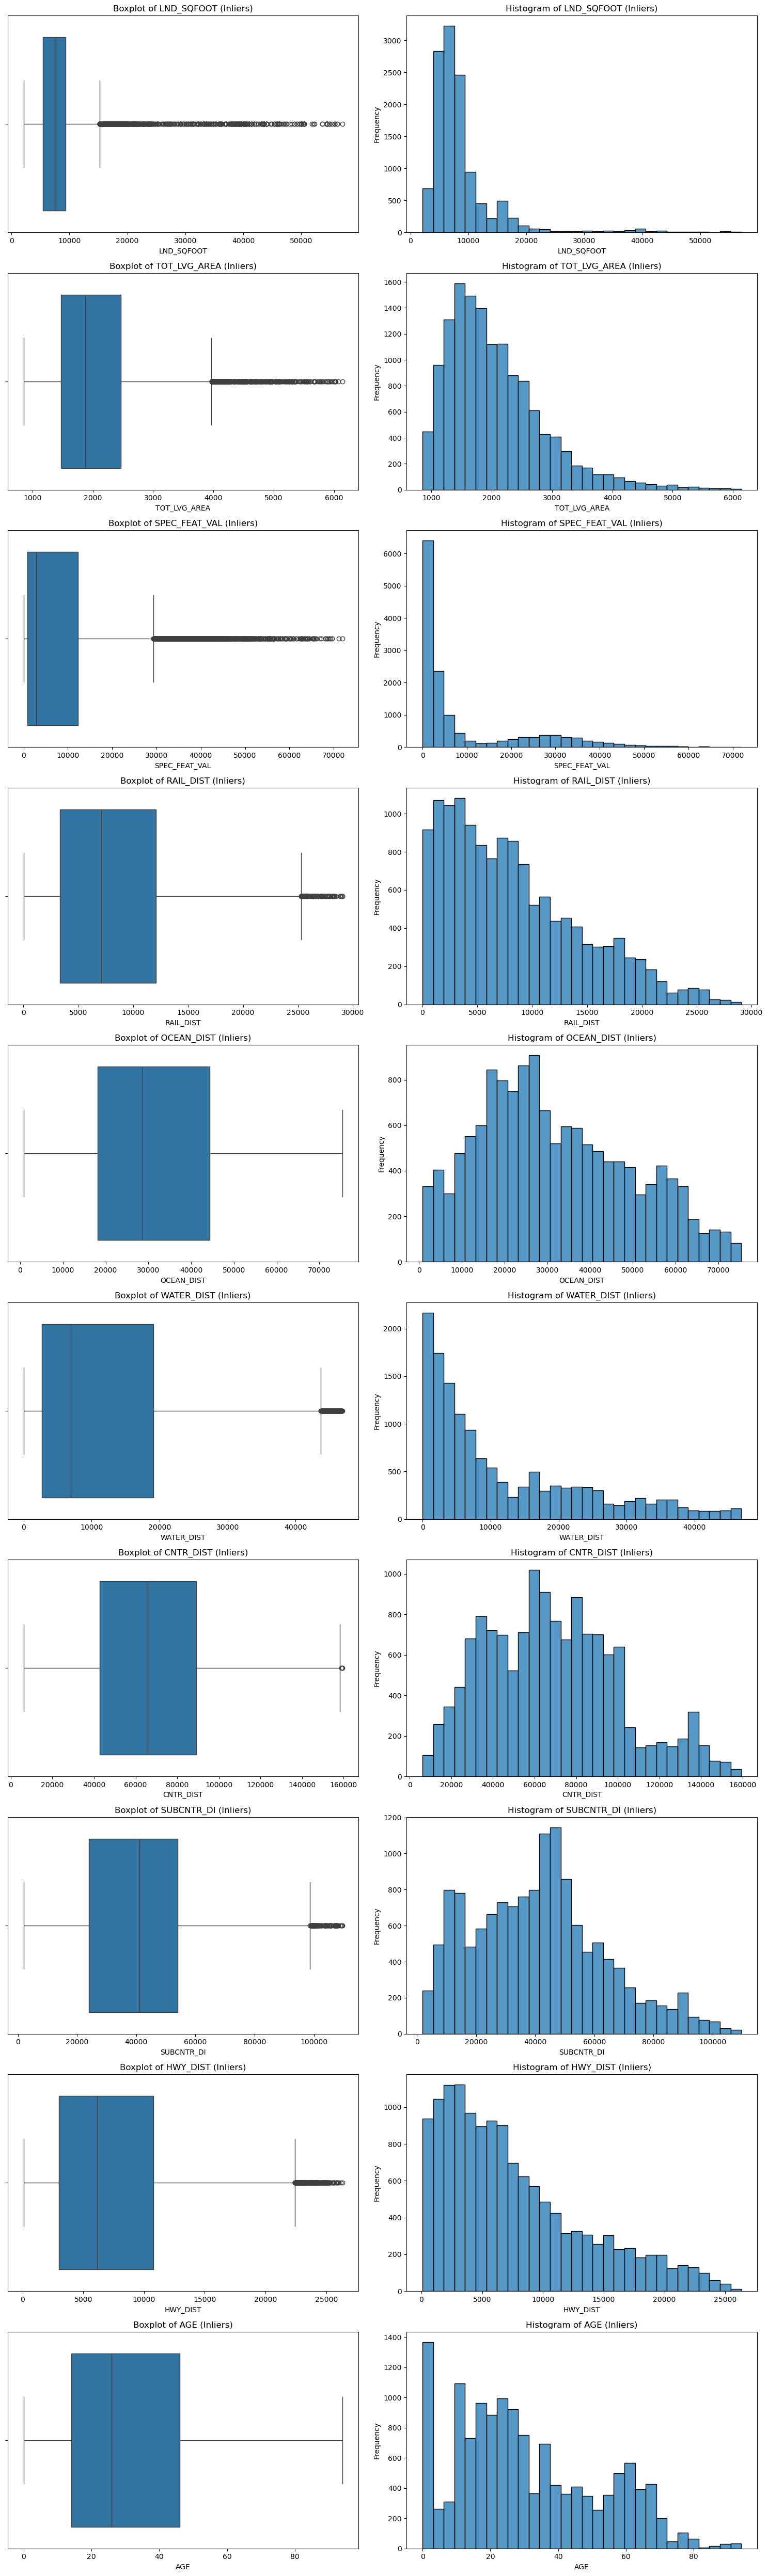

In [24]:
#### I will use the Local Outlier Factor approach to find outliers in the target variable (SALE_PRC):

numerical_columns = ['LND_SQFOOT', 'TOT_LVG_AREA', 'SPEC_FEAT_VAL', 'RAIL_DIST', 'OCEAN_DIST', 
                     'WATER_DIST', 'CNTR_DIST', 'SUBCNTR_DI', 'HWY_DIST', 'AGE']

local_outlier_factor = LocalOutlierFactor(n_neighbors=50)

num_rows = len(numerical_columns)
fig, axes = plt.subplots(num_rows, 2, figsize=(15, 5 * num_rows))

for i, col in enumerate(numerical_columns):
    result = local_outlier_factor.fit_predict(df[col].values.reshape(-1, 1))
    
    inliers = result == 1
    outliers = result == -1
    
    print(f"Counter for {col}: {Counter(result)}")
    
    sns.boxplot(x=df[inliers][col], ax=axes[i, 0])
    axes[i, 0].set_title(f'Boxplot of {col} (Inliers)')
    axes[i, 0].set_xlabel(col)
    
    sns.histplot(df[inliers][col], bins=30, kde=False, ax=axes[i, 1])
    axes[i, 1].set_title(f'Histogram of {col} (Inliers)')
    axes[i, 1].set_xlabel(col)
    axes[i, 1].set_ylabel('Frequency')

plt.tight_layout()
plt.show()

In [25]:
####I don't observe any significant outliers in any of the numerical variables, so no treatment needs to be done

### Treatment of cathegorical variables

In [26]:
df.AVNO60PLUS.replace([0, 1],
                          ["soroll_acceptable","soroll_no_acceptable"],
                          inplace=True)

df.STRUCTURE_QUALITY = df.STRUCTURE_QUALITY.astype('object')
                      
df.MONTH_SOLD.replace([1,2,3,4,5,6,7,8,9,10,11,12],
                             ["gener", "febrer", "març", "abril", "maig", "juny",
                              "juliol", "agost", "setembre", "octubre", "novembre", "desembre"],
                             inplace=True)


C:\Users\Santiago\AppData\Local\Temp\ipykernel_12828\225760194.py:1: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df.AVNO60PLUS.replace([0, 1],
C:\Users\Santiago\AppData\Local\Temp\ipykernel_12828\225760194.py:7: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doin

In [27]:
df.dtypes

SALE_PRC               int64
LND_SQFOOT             int64
TOT_LVG_AREA           int64
SPEC_FEAT_VAL          int64
RAIL_DIST              int64
OCEAN_DIST           float64
WATER_DIST             int64
CNTR_DIST            float64
SUBCNTR_DI             int64
HWY_DIST               int64
AGE                    int64
AVNO60PLUS            object
MONTH_SOLD            object
STRUCTURE_QUALITY     object
dtype: object

### Dataset so far

In [28]:
df_new =df.copy()

df_new.describe(include='all')
df_new['SPEC_FEAT_VAL'].value_counts()

,SALE_PRC,LND_SQFOOT,TOT_LVG_AREA,SPEC_FEAT_VAL,RAIL_DIST,OCEAN_DIST,WATER_DIST,CNTR_DIST,SUBCNTR_DI,HWY_DIST,AGE,AVNO60PLUS,MONTH_SOLD,STRUCTURE_QUALITY
count,1.393e+04,13932.000,13932.000,13932.000,13932.000,13932.000,13932.000,13932.000,13932.000,13932.000,13932.000,13932,13932,13932.0
unique,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2,12,5.0
top,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,soroll_acceptable,juny,4.0
freq,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,13724,1387,7623.0
mean,3.999e+05,8620.880,2058.045,9562.493,8348.100,31685.715,11959.837,68496.619,41114.596,7723.320,30.669,NaN,NaN,NaN
std,3.172e+05,6070.089,813.539,13890.968,6178.029,17583.666,11932.985,32000.577,22161.821,6068.939,21.153,NaN,NaN,NaN
min,7.200e+04,1248.000,854.000,0.000,10.000,236.000,0.000,3825.000,1462.000,90.000,0.000,NaN,NaN,NaN
25%,2.350e+05,5400.000,1470.000,810.000,3299.000,18096.750,2675.750,42848.500,23995.750,2997.750,14.000,NaN,NaN,NaN
50%,3.100e+05,7500.000,1877.500,2765.500,7105.500,28545.000,6922.000,65854.000,41109.500,6159.000,26.000,NaN,NaN,NaN
75%,4.280e+05,9126.250,2471.000,12352.250,12102.000,44298.000,19199.750,89345.750,53949.000,10853.500,46.000,NaN,NaN,NaN


SPEC_FEAT_VAL
0        2290
550        45
440        27
4800       23
1200       22
         ... 
28773       1
6805        1
28668       1
34400       1
6580        1
Name: count, Length: 7583, dtype: int64

### Gaussianity and transformations

In [29]:
#I'll plot histogram of all numerical variables in order to see if they need a gaussianity transformation:

(array([1.006e+03, 4.804e+03, 5.104e+03, 1.221e+03, 7.000e+02, 4.800e+02,
        1.660e+02, 8.000e+01, 3.800e+01, 2.700e+01, 2.900e+01, 3.500e+01,
        3.800e+01, 8.100e+01, 2.500e+01, 3.800e+01, 1.500e+01, 2.000e+01,
        5.000e+00, 2.000e+01]),
 array([ 1248. ,  4038.8,  6829.6,  9620.4, 12411.2, 15202. , 17992.8,
        20783.6, 23574.4, 26365.2, 29156. , 31946.8, 34737.6, 37528.4,
        40319.2, 43110. , 45900.8, 48691.6, 51482.4, 54273.2, 57064. ]),
 <BarContainer object of 20 artists>)

Text(0.5, 1.0, 'LND_SQFOOT')

Text(0.5, 0, 'Value')

Text(0, 0.5, 'Frequency')

(array([ 895., 1950., 2400., 2156., 1737., 1363., 1174.,  658.,  549.,
         294.,  214.,  177.,  107.,   82.,   50.,   48.,   30.,   21.,
          18.,    9.]),
 array([ 854.  , 1125.65, 1397.3 , 1668.95, 1940.6 , 2212.25, 2483.9 ,
        2755.55, 3027.2 , 3298.85, 3570.5 , 3842.15, 4113.8 , 4385.45,
        4657.1 , 4928.75, 5200.4 , 5472.05, 5743.7 , 6015.35, 6287.  ]),
 <BarContainer object of 20 artists>)

Text(0.5, 1.0, 'TOT_LVG_AREA')

Text(0.5, 0, 'Value')

Text(0, 0.5, 'Frequency')

(array([1.0114e+04, 5.9500e+02, 9.7600e+02, 1.2380e+03, 6.3600e+02,
        2.1500e+02, 9.0000e+01, 3.9000e+01, 1.1000e+01, 8.0000e+00,
        3.0000e+00, 3.0000e+00, 2.0000e+00, 0.0000e+00, 1.0000e+00,
        0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 1.0000e+00]),
 array([     0.,   8751.,  17502.,  26253.,  35004.,  43755.,  52506.,
         61257.,  70008.,  78759.,  87510.,  96261., 105012., 113763.,
        122514., 131265., 140016., 148767., 157518., 166269., 175020.]),
 <BarContainer object of 20 artists>)

Text(0.5, 1.0, 'SPEC_FEAT_VAL')

Text(0.5, 0, 'Value')

Text(0, 0.5, 'Frequency')

(array([1455., 1645., 1603., 1285., 1241., 1312.,  974.,  801.,  679.,
         609.,  455.,  504.,  418.,  365.,  202.,   92.,  144.,   96.,
          34.,   18.]),
 array([1.000000e+01, 1.490550e+03, 2.971100e+03, 4.451650e+03,
        5.932200e+03, 7.412750e+03, 8.893300e+03, 1.037385e+04,
        1.185440e+04, 1.333495e+04, 1.481550e+04, 1.629605e+04,
        1.777660e+04, 1.925715e+04, 2.073770e+04, 2.221825e+04,
        2.369880e+04, 2.517935e+04, 2.665990e+04, 2.814045e+04,
        2.962100e+04]),
 <BarContainer object of 20 artists>)

Text(0.5, 1.0, 'RAIL_DIST')

Text(0.5, 0, 'Value')

Text(0, 0.5, 'Frequency')

(array([ 457.,  532.,  724.,  859., 1264., 1139., 1278., 1192.,  807.,
         924.,  764.,  705.,  663.,  500.,  550.,  598.,  428.,  201.,
         227.,  120.]),
 array([  236. ,  4011.4,  7786.8, 11562.2, 15337.6, 19113. , 22888.4,
        26663.8, 30439.2, 34214.6, 37990. , 41765.4, 45540.8, 49316.2,
        53091.6, 56867. , 60642.4, 64417.8, 68193.2, 71968.6, 75744. ]),
 <BarContainer object of 20 artists>)

Text(0.5, 1.0, 'OCEAN_DIST')

Text(0.5, 0, 'Value')

Text(0, 0.5, 'Frequency')

(array([3336., 2306., 1675., 1008.,  680.,  445.,  701.,  518.,  541.,
         539.,  387.,  251.,  330.,  277.,  320.,  183.,  123.,  151.,
         128.,   33.]),
 array([    0.  ,  2519.95,  5039.9 ,  7559.85, 10079.8 , 12599.75,
        15119.7 , 17639.65, 20159.6 , 22679.55, 25199.5 , 27719.45,
        30239.4 , 32759.35, 35279.3 , 37799.25, 40319.2 , 42839.15,
        45359.1 , 47879.05, 50399.  ]),
 <BarContainer object of 20 artists>)

Text(0.5, 1.0, 'WATER_DIST')

Text(0.5, 0, 'Value')

Text(0, 0.5, 'Frequency')

(array([ 124.,  433.,  664., 1109., 1155.,  931., 1061., 1562., 1162.,
        1218., 1060., 1014.,  881.,  229.,  243.,  242.,  371.,  298.,
         122.,   53.]),
 array([  3825.  ,  11632.55,  19440.1 ,  27247.65,  35055.2 ,  42862.75,
         50670.3 ,  58477.85,  66285.4 ,  74092.95,  81900.5 ,  89708.05,
         97515.6 , 105323.15, 113130.7 , 120938.25, 128745.8 , 136553.35,
        144360.9 , 152168.45, 159976.  ]),
 <BarContainer object of 20 artists>)

Text(0.5, 1.0, 'CNTR_DIST')

Text(0.5, 0, 'Value')

Text(0, 0.5, 'Frequency')

(array([ 408., 1063., 1067.,  806., 1027., 1099., 1184., 1527., 1612.,
         987.,  774.,  604.,  476.,  316.,  265.,  224.,  245.,  154.,
          61.,   33.]),
 array([  1462.  ,   6916.55,  12371.1 ,  17825.65,  23280.2 ,  28734.75,
         34189.3 ,  39643.85,  45098.4 ,  50552.95,  56007.5 ,  61462.05,
         66916.6 ,  72371.15,  77825.7 ,  83280.25,  88734.8 ,  94189.35,
         99643.9 , 105098.45, 110553.  ]),
 <BarContainer object of 20 artists>)

Text(0.5, 1.0, 'SUBCNTR_DI')

Text(0.5, 0, 'Value')

Text(0, 0.5, 'Frequency')

(array([2.835e+03, 2.838e+03, 2.412e+03, 1.722e+03, 1.147e+03, 8.280e+02,
        7.300e+02, 5.540e+02, 4.230e+02, 3.050e+02, 7.900e+01, 2.700e+01,
        4.000e+00, 6.000e+00, 1.000e+01, 5.000e+00, 4.000e+00, 0.000e+00,
        1.000e+00, 2.000e+00]),
 array([   90.  ,  2493.85,  4897.7 ,  7301.55,  9705.4 , 12109.25,
        14513.1 , 16916.95, 19320.8 , 21724.65, 24128.5 , 26532.35,
        28936.2 , 31340.05, 33743.9 , 36147.75, 38551.6 , 40955.45,
        43359.3 , 45763.15, 48167.  ]),
 <BarContainer object of 20 artists>)

Text(0.5, 1.0, 'HWY_DIST')

Text(0.5, 0, 'Value')

Text(0, 0.5, 'Frequency')

(array([1439.,  502., 1606., 1414., 1247., 1326., 1012.,  949.,  630.,
         501.,  436.,  588.,  909.,  728.,  315.,  110.,  123.,   25.,
          56.,   16.]),
 array([ 0. ,  4.8,  9.6, 14.4, 19.2, 24. , 28.8, 33.6, 38.4, 43.2, 48. ,
        52.8, 57.6, 62.4, 67.2, 72. , 76.8, 81.6, 86.4, 91.2, 96. ]),
 <BarContainer object of 20 artists>)

Text(0.5, 1.0, 'AGE')

Text(0.5, 0, 'Value')

Text(0, 0.5, 'Frequency')

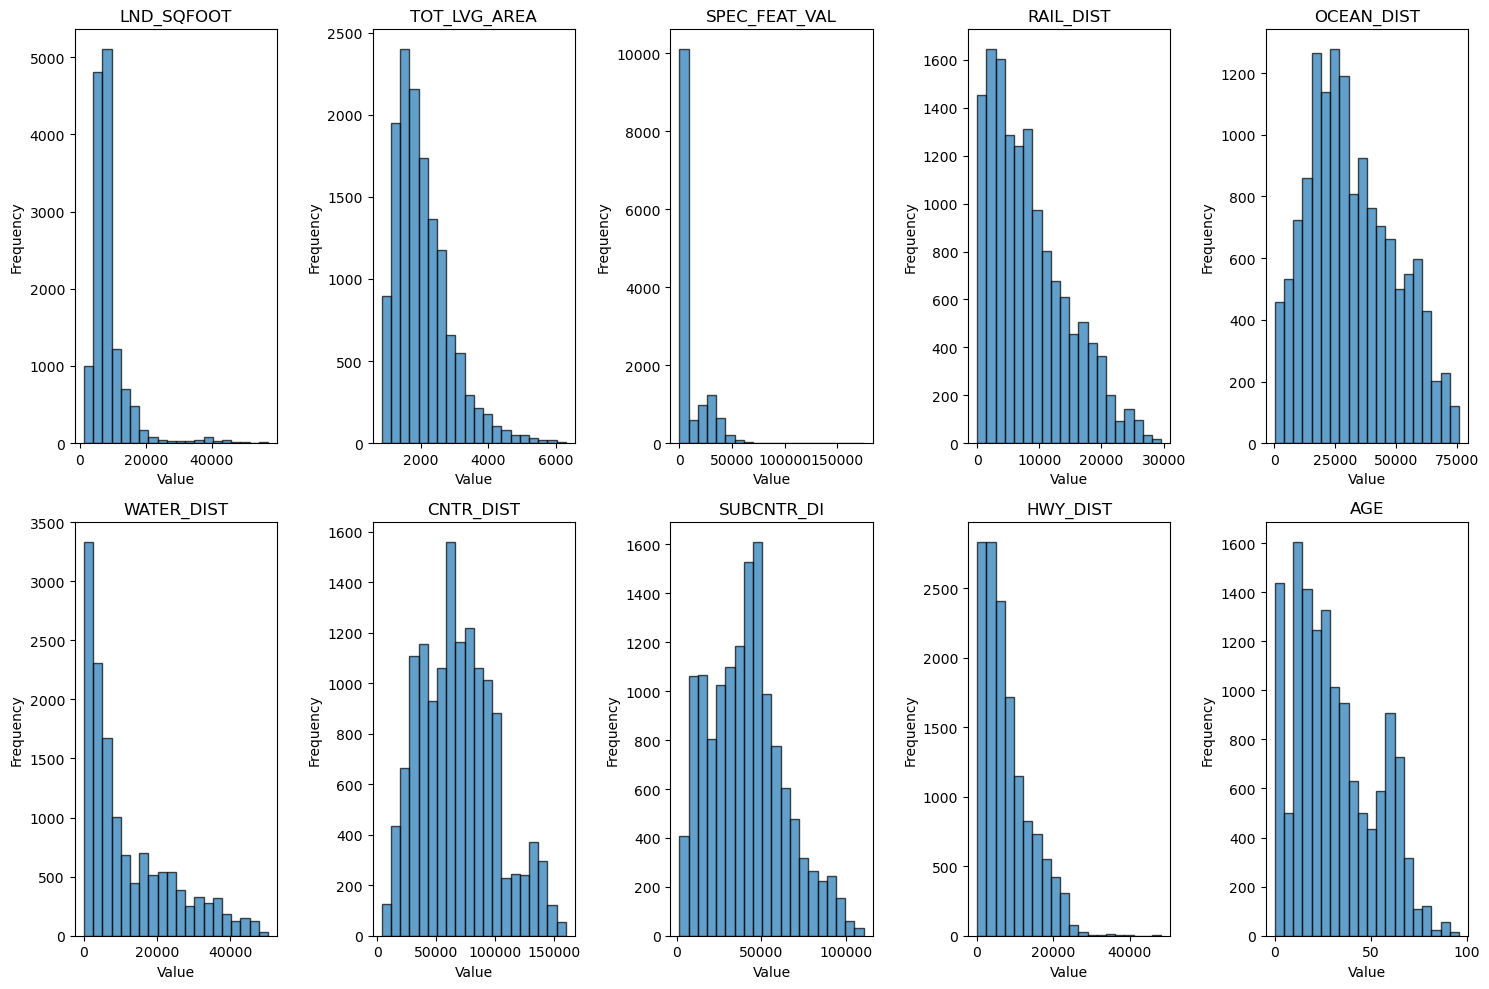

In [30]:
numerical_columns = ['LND_SQFOOT', 'TOT_LVG_AREA', 'SPEC_FEAT_VAL', 'RAIL_DIST', 'OCEAN_DIST', 
                     'WATER_DIST', 'CNTR_DIST', 'SUBCNTR_DI', 'HWY_DIST', 'AGE']

num_plots = len(numerical_columns)
num_cols = 5
num_rows = 2

fig, axes = plt.subplots(num_rows, num_cols, figsize=(15, 5 * num_rows))

axes = axes.flatten()

for i, col in enumerate(numerical_columns):
    ax = axes[i]
    ax.hist(df[col], bins=20, edgecolor='black', alpha=0.7)
    ax.set_title(col)
    ax.set_xlabel('Value')
    ax.set_ylabel('Frequency')

# Remove any unused subplots
for j in range(i + 1, len(axes)):
    fig.delaxes(axes[j])

plt.tight_layout()
plt.show()

In [31]:
#I can observe that specially LND_SQFOOT, TOT_LVG_AREA and HWY_DIST need logarithmic transformation:

(array([   9.,    7.,   20.,   53.,  210.,  514.,  964., 2294., 1920.,
        3656., 1706.,  767.,  471.,  745.,  187.,   78.,   58.,  112.,
         111.,   50.]),
 array([3.09621459, 3.17922197, 3.26222935, 3.34523673, 3.42824411,
        3.51125149, 3.59425887, 3.67726625, 3.76027364, 3.84328102,
        3.9262884 , 4.00929578, 4.09230316, 4.17531054, 4.25831792,
        4.3413253 , 4.42433269, 4.50734007, 4.59034745, 4.67335483,
        4.75636221]),
 <BarContainer object of 20 artists>)

Text(0.5, 1.0, 'LND_SQFOOT')

Text(0.5, 0, 'Value')

Text(0, 0.5, 'Frequency')

(array([ 179.,  322.,  538.,  859., 1025., 1344., 1408., 1433., 1288.,
        1351., 1119.,  982.,  716.,  514.,  301.,  236.,  141.,   93.,
          55.,   28.]),
 array([2.93145787, 2.97480715, 3.01815643, 3.06150571, 3.10485499,
        3.14820427, 3.19155355, 3.23490283, 3.27825211, 3.32160139,
        3.36495067, 3.40829995, 3.45164922, 3.4949985 , 3.53834778,
        3.58169706, 3.62504634, 3.66839562, 3.7117449 , 3.75509418,
        3.79844346]),
 <BarContainer object of 20 artists>)

Text(0.5, 1.0, 'TOT_LVG_AREA')

Text(0.5, 0, 'Value')

Text(0, 0.5, 'Frequency')

(array([  27.,   21.,   53.,   90.,  131.,  178.,  258.,  346.,  485.,
         706.,  989., 1299., 1512., 2006., 1879., 1550., 1415.,  920.,
          50.,   17.]),
 array([1.95424251, 2.09066786, 2.22709322, 2.36351857, 2.49994393,
        2.63636928, 2.77279464, 2.90921999, 3.04564534, 3.1820707 ,
        3.31849605, 3.45492141, 3.59134676, 3.72777212, 3.86419747,
        4.00062283, 4.13704818, 4.27347353, 4.40989889, 4.54632424,
        4.6827496 ]),
 <BarContainer object of 20 artists>)

Text(0.5, 1.0, 'HWY_DIST')

Text(0.5, 0, 'Value')

Text(0, 0.5, 'Frequency')

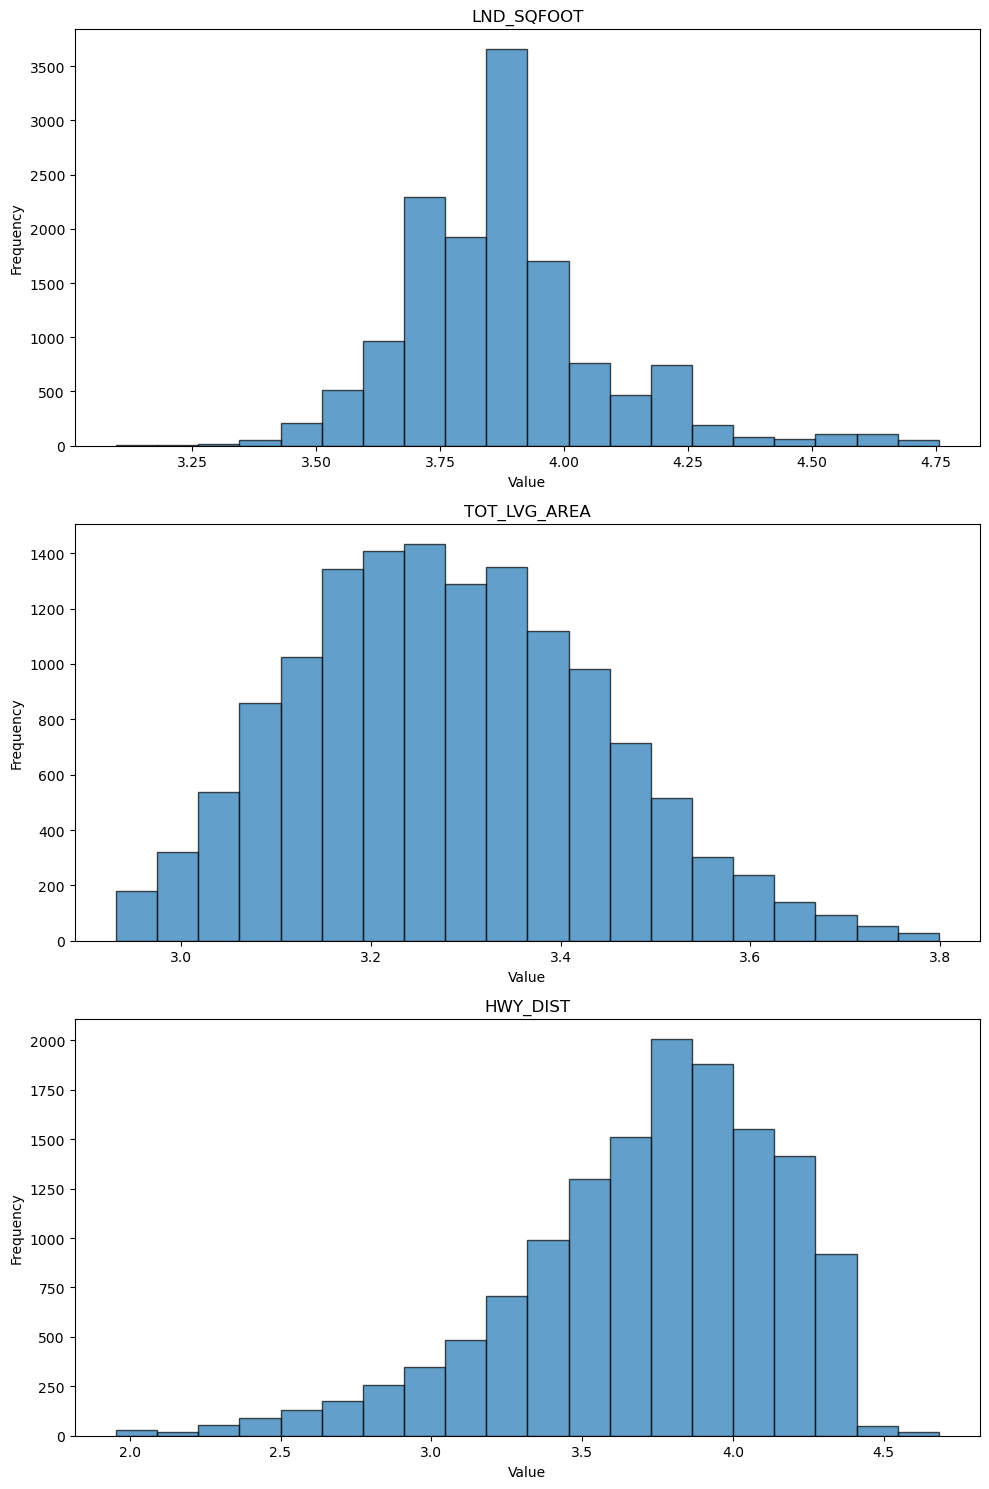

In [32]:
def safe_log(x):
    if x <= 0:
        return x  
    else:
        return np.log10(x)  

#Apply log to each column
df['LND_SQFOOT'] = df['LND_SQFOOT'].apply(safe_log)
df['TOT_LVG_AREA'] = df['TOT_LVG_AREA'].apply(safe_log)
df['HWY_DIST'] = df['HWY_DIST'].apply(safe_log)

numerical_columns = ['LND_SQFOOT', 'TOT_LVG_AREA', 'HWY_DIST']

num_plots = len(numerical_columns)
fig, axes = plt.subplots(num_plots, 1, figsize=(10, 5*num_plots))

for i, col in enumerate(numerical_columns):
    ax = axes[i]
    ax.hist(df[col], bins=20, edgecolor='black', alpha=0.7)
    ax.set_title(col)
    ax.set_xlabel('Value')
    ax.set_ylabel('Frequency')

plt.tight_layout()
plt.show()

In [33]:
#Much better
df.describe(include='all')

,SALE_PRC,LND_SQFOOT,TOT_LVG_AREA,SPEC_FEAT_VAL,RAIL_DIST,OCEAN_DIST,WATER_DIST,CNTR_DIST,SUBCNTR_DI,HWY_DIST,AGE,AVNO60PLUS,MONTH_SOLD,STRUCTURE_QUALITY
count,1.393e+04,13932.000,13932.000,13932.000,13932.000,13932.000,13932.000,13932.000,13932.000,13932.000,13932.000,13932,13932,13932.0
unique,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2,12,5.0
top,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,soroll_acceptable,juny,4.0
freq,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,13724,1387,7623.0
mean,3.999e+05,3.875,3.283,9562.493,8348.100,31685.715,11959.837,68496.619,41114.596,3.721,30.669,NaN,NaN,NaN
std,3.172e+05,0.210,0.159,13890.968,6178.029,17583.666,11932.985,32000.577,22161.821,0.434,21.153,NaN,NaN,NaN
min,7.200e+04,3.096,2.931,0.000,10.000,236.000,0.000,3825.000,1462.000,1.954,0.000,NaN,NaN,NaN
25%,2.350e+05,3.732,3.167,810.000,3299.000,18096.750,2675.750,42848.500,23995.750,3.477,14.000,NaN,NaN,NaN
50%,3.100e+05,3.875,3.274,2765.500,7105.500,28545.000,6922.000,65854.000,41109.500,3.790,26.000,NaN,NaN,NaN
75%,4.280e+05,3.960,3.393,12352.250,12102.000,44298.000,19199.750,89345.750,53949.000,4.036,46.000,NaN,NaN,NaN


### NORMALIZATION

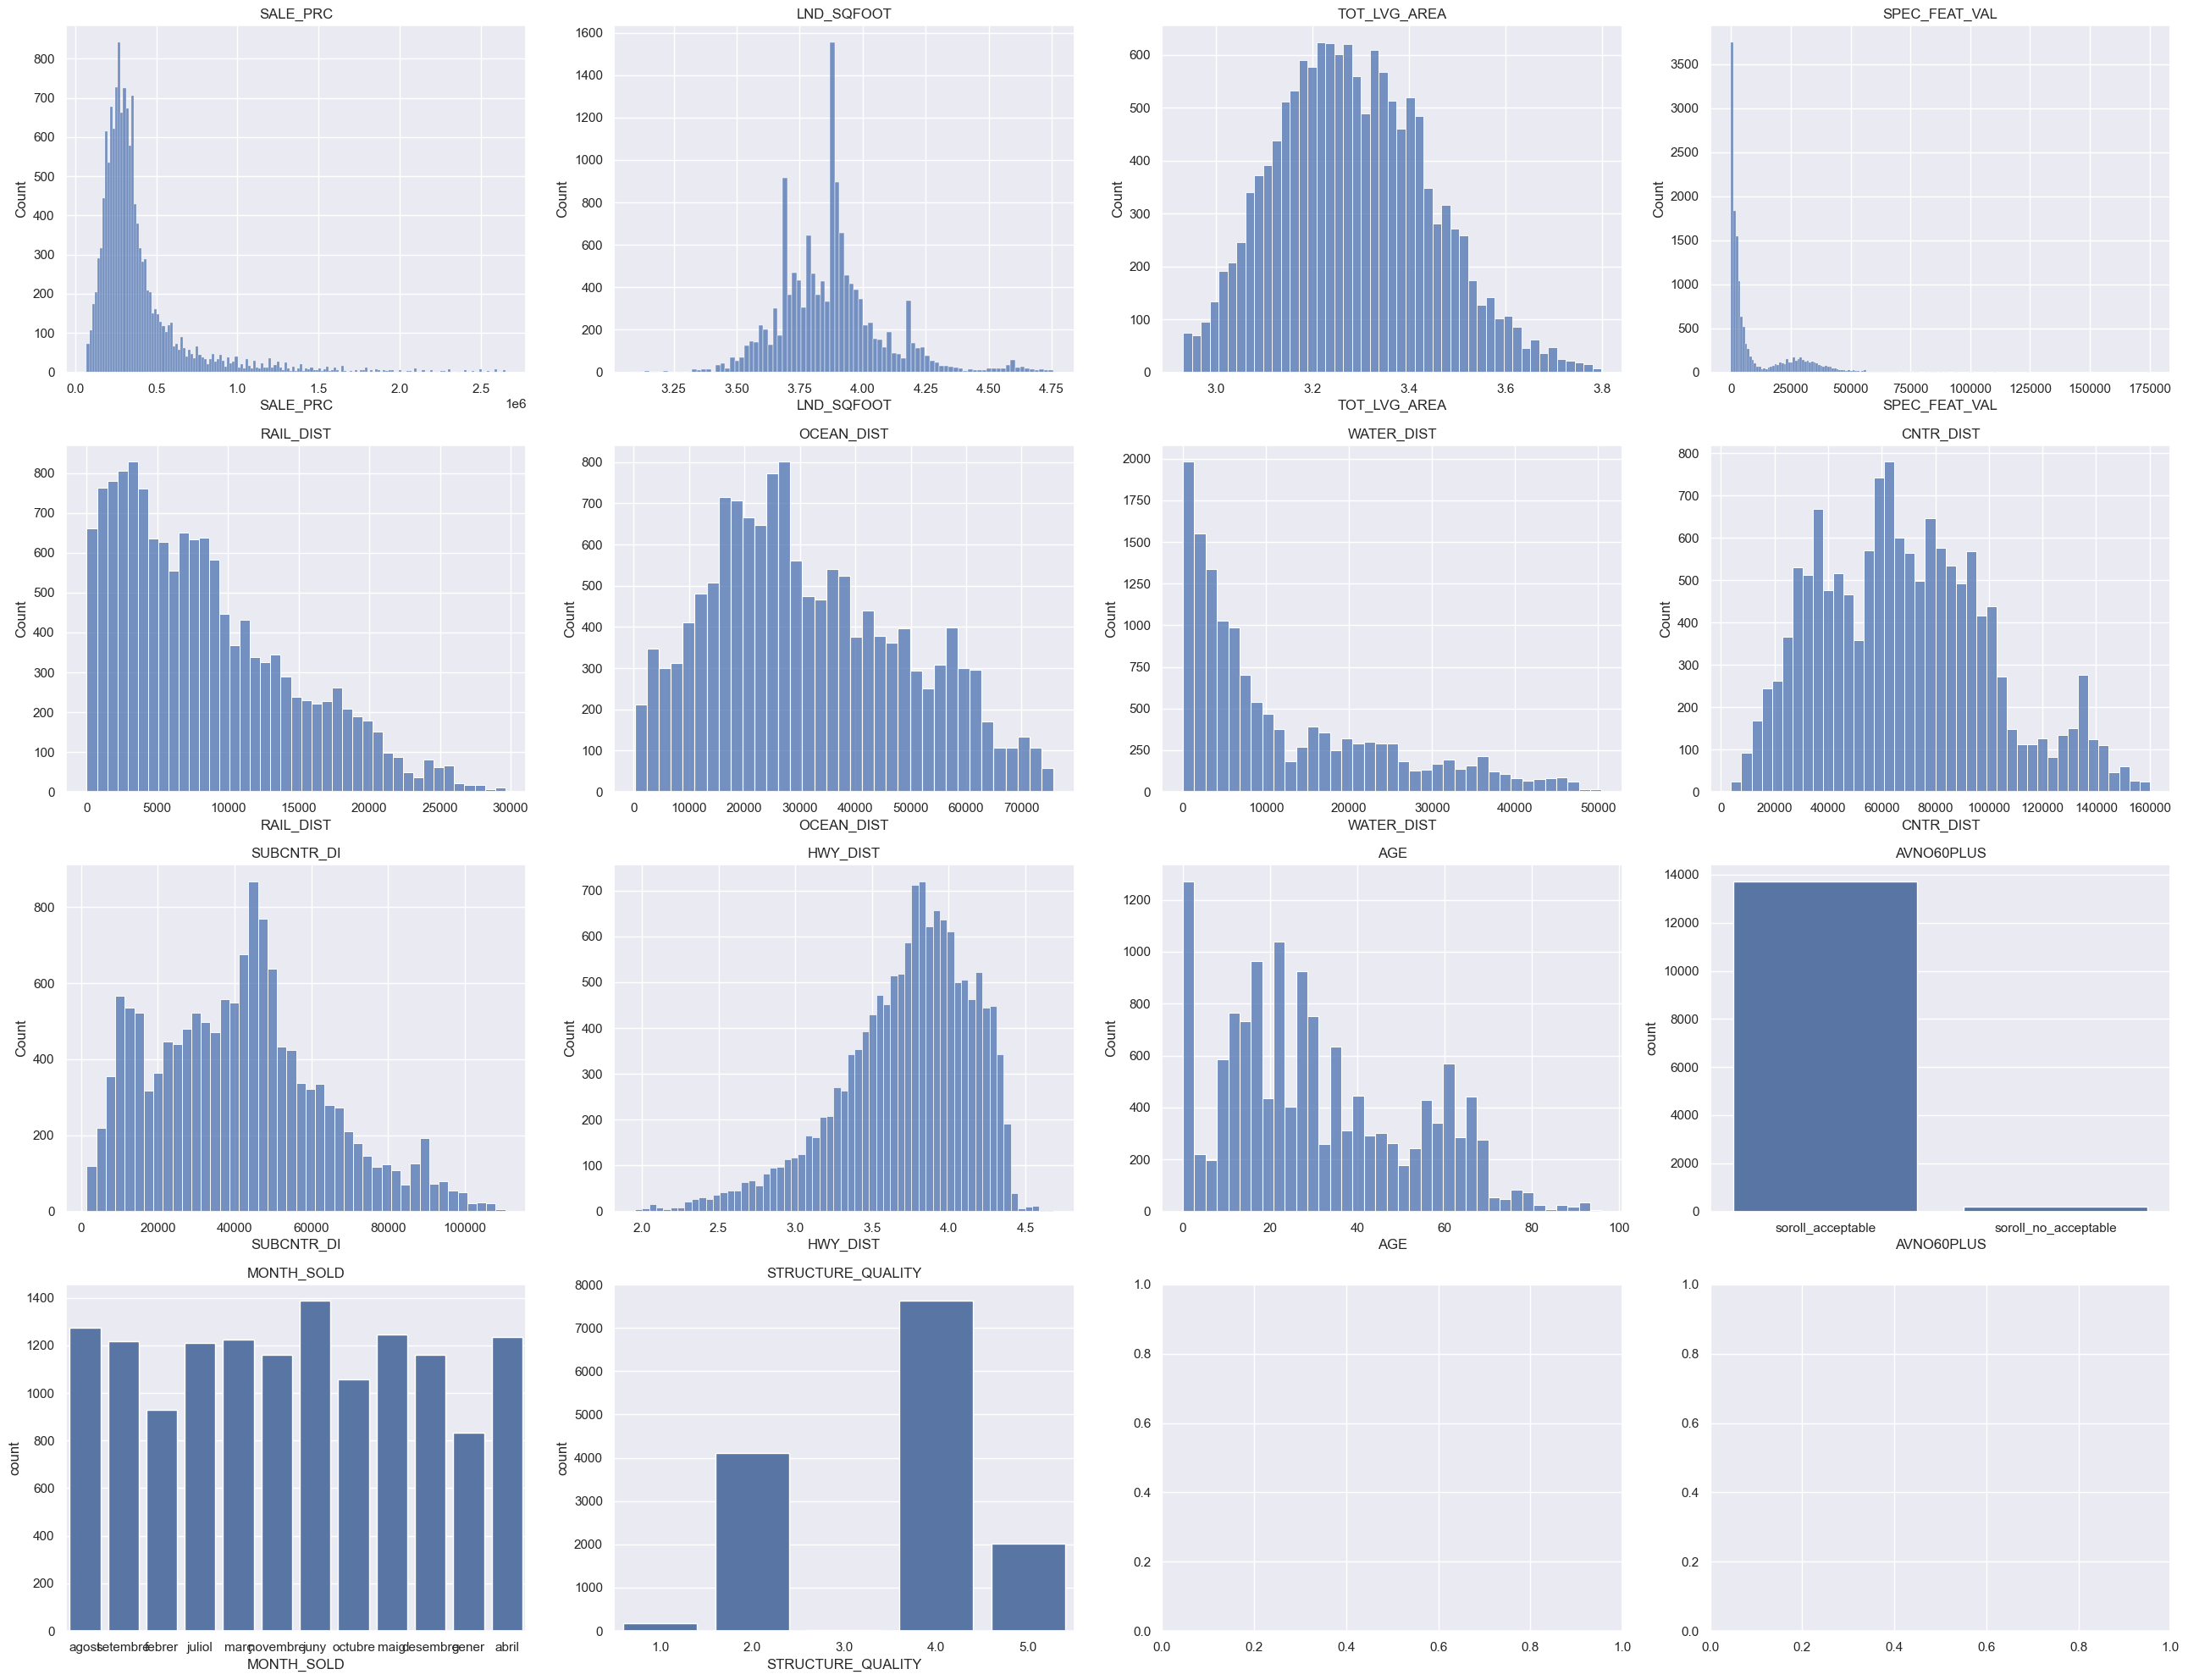

In [34]:
#let's check the ranges:
sns.set()
pd.set_option('display.precision', 3)

fig, axes = plt.subplots(4,4,figsize=(26,20))

for i, c in enumerate(df.columns[0:]):
    ax = axes.reshape(-1)[i]
    if df[c].dtype.kind == 'O':
        a = sns.countplot(x=c,data=df,ax=ax)
    else:
        b = sns.histplot(x=c,data=df,ax=ax)
    t = ax.set_title(c)
plt.tight_layout()

In [35]:
#Normalization
#Variables in my dataset take values in ranges really different, so it's a good idea to normalize the data.
#I'll be using min-max scaling on all numerical variables so future models give better results

In [36]:
# Before
numerical_features = ['LND_SQFOOT', 'TOT_LVG_AREA', 'SPEC_FEAT_VAL', 'RAIL_DIST', 'OCEAN_DIST',
                      'WATER_DIST', 'CNTR_DIST', 'SUBCNTR_DI', 'HWY_DIST', 'AGE']
numerical_df = df[numerical_features]

numerical_df.describe()

,LND_SQFOOT,TOT_LVG_AREA,SPEC_FEAT_VAL,RAIL_DIST,OCEAN_DIST,WATER_DIST,CNTR_DIST,SUBCNTR_DI,HWY_DIST,AGE
count,13932.000,13932.000,13932.000,13932.000,13932.000,13932.000,13932.000,13932.000,13932.000,13932.000
mean,3.875,3.283,9562.493,8348.100,31685.715,11959.837,68496.619,41114.596,3.721,30.669
std,0.210,0.159,13890.968,6178.029,17583.666,11932.985,32000.577,22161.821,0.434,21.153
min,3.096,2.931,0.000,10.000,236.000,0.000,3825.000,1462.000,1.954,0.000
25%,3.732,3.167,810.000,3299.000,18096.750,2675.750,42848.500,23995.750,3.477,14.000
50%,3.875,3.274,2765.500,7105.500,28545.000,6922.000,65854.000,41109.500,3.790,26.000
75%,3.960,3.393,12352.250,12102.000,44298.000,19199.750,89345.750,53949.000,4.036,46.000
max,4.756,3.798,175020.000,29621.000,75744.000,50399.000,159976.000,110553.000,4.683,96.000


In [37]:
#After
# Apply Min-Max scaling
scaler = MinMaxScaler()
df[numerical_features] = scaler.fit_transform(df[numerical_features])

df.describe()

,SALE_PRC,LND_SQFOOT,TOT_LVG_AREA,SPEC_FEAT_VAL,RAIL_DIST,OCEAN_DIST,WATER_DIST,CNTR_DIST,SUBCNTR_DI,HWY_DIST,AGE
count,1.393e+04,13932.000,13932.000,13932.000,13932.000,13932.000,13932.000,13932.000,13932.000,13932.000,13932.000
mean,3.999e+05,0.469,0.406,0.055,0.282,0.417,0.237,0.414,0.363,0.647,0.319
std,3.172e+05,0.127,0.183,0.079,0.209,0.233,0.237,0.205,0.203,0.159,0.220
min,7.200e+04,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000
25%,2.350e+05,0.383,0.272,0.005,0.111,0.237,0.053,0.250,0.207,0.558,0.146
50%,3.100e+05,0.469,0.395,0.016,0.240,0.375,0.137,0.397,0.363,0.673,0.271
75%,4.280e+05,0.520,0.532,0.071,0.408,0.584,0.381,0.548,0.481,0.763,0.479
max,2.650e+06,1.000,1.000,1.000,1.000,1.000,1.000,1.000,1.000,1.000,1.000


# MODELING

### REGRESSION

In [38]:
#To do linear regreesion there can't be categorical variables, so I'll apply one-hot encoding 

In [39]:
df_linear = df.copy()

In [40]:
encoded_df = pd.get_dummies(df_linear, columns=['AVNO60PLUS', 'STRUCTURE_QUALITY', 'MONTH_SOLD'])

In [41]:
encoded_df.dtypes

SALE_PRC                             int64
LND_SQFOOT                         float64
TOT_LVG_AREA                       float64
SPEC_FEAT_VAL                      float64
RAIL_DIST                          float64
OCEAN_DIST                         float64
WATER_DIST                         float64
CNTR_DIST                          float64
SUBCNTR_DI                         float64
HWY_DIST                           float64
AGE                                float64
AVNO60PLUS_soroll_acceptable          bool
AVNO60PLUS_soroll_no_acceptable       bool
STRUCTURE_QUALITY_1.0                 bool
STRUCTURE_QUALITY_2.0                 bool
STRUCTURE_QUALITY_3.0                 bool
STRUCTURE_QUALITY_4.0                 bool
STRUCTURE_QUALITY_5.0                 bool
MONTH_SOLD_abril                      bool
MONTH_SOLD_agost                      bool
MONTH_SOLD_desembre                   bool
MONTH_SOLD_febrer                     bool
MONTH_SOLD_gener                      bool
MONTH_SOLD_

In [42]:
encoded_df.shape

(13932, 30)

In [43]:
X = encoded_df.loc[:,encoded_df.columns != 'SALE_PRC']
y = encoded_df['SALE_PRC']

In [44]:
#Resampling Protocol

In [45]:
#Divide data into training set and temporary set to later divide temporary set into validation and test set.
X_train, X_temp, y_train, y_temp = train_test_split(X, y, test_size=0.3, random_state=42)

# Split temporary set into validation and test
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, random_state=42)

#Check the sizes of sets
X_train.shape
y_train.shape
X_val.shape
y_val.shape
X_test.shape
y_test.shape

(9752, 29)

(9752,)

(2090, 29)

(2090,)

(2090, 29)

(2090,)

### NO REGULARIZATION REGRESSION

In [46]:
#Sklearn linear regression no regularization

# We instantiate a linear regression. 
lr = LinearRegression()

# Now we train it on train data with fit method
lr.fit(X_train,y_train)

# We can predict using the predict method
y_pred = lr.predict(X_train)

weights = lr.coef_
intercept = lr.intercept_

print('Coefficients: \n', weights)
print('Intercept: \n', intercept)

pred_val = lr.predict(X_val)
r2_score(y_val, pred_val)

LinearRegression()

Coefficients: 
 [ 265148.72670905  706956.05986984  571739.26897647  129618.12707595
 -309226.78486687   77963.93357903 -450934.86309183  -76459.11965697
  140429.10161739 -190490.2781011    45852.72259042  -45852.72259041
 -329204.82887868 -270118.12393932  794378.2991763  -222369.29239955
   27313.94604127   -6084.97922261   -2763.14895734   -4811.34632141
   -1282.31969581   -2100.55588458    5609.29695297    1563.07913177
    9919.1866342    -2179.6162694     6738.40940841   -1516.01868555
   -3091.98709071]
Intercept: 
 371187.77171563735


0.6911402363080366

In [47]:
p = 1                   # smallest degree to try
q = 3                  # largest degree to try  (minus 1, see code below)

coef = []               # holds coefficients of trained polynomials from degree p=1 up to q=2
model = []              # holds trained polynomials from degree p=1 up to q=2
mse_train = []     # holds training error for trained polynomials from degree p=1 up to q=2
mse_valid = []     # holds validation error for trained polynomials from degree p=1 up to q=2
norm_mse_train = [] #holds normalized mse in training
norm_mse_valid = [] #holds normalized mse in validation
r_squared_train = [] #holds r squared for training
r_squared_valid = [] #holds r squared for validation
for i in range(p, q):
    cmodel = LinearRegression()
    poly = PolynomialFeatures(degree=i)
    X_train_poly = poly.fit_transform(X_train)
    X_val_poly = poly.transform(X_val)
    cmodel.fit(X_train_poly, y_train)
    coef.append(cmodel.coef_)
    
    predictions = cmodel.predict(X_train_poly)
    mse_train.append(mean_squared_error(predictions, y_train))
    
    norm_mse_train.append(1-r2_score(y_train,predictions))
    
    r_squared_train.append(r2_score(y_train,predictions))
    
    pred_val = cmodel.predict(X_val_poly)
    mse_valid.append(mean_squared_error(pred_val, y_val))
    
    norm_mse_valid.append(1-r2_score(y_val, pred_val))
    
    r_squared_valid.append(r2_score(y_val, pred_val))
    
    model.append(cmodel)
    

LinearRegression()

LinearRegression()

In [48]:
mse_train
mse_valid

norm_mse_train
norm_mse_valid

r_squared_train
r_squared_valid
#Degree 1 has the worse training R2 but a similar validation R2 -> This model generalizes well, with close training and validation errors, and positive R-squared values. It’s a good balance between bias and variance.
#Degree 2 has better training R2 but much worse validation R2 -> This model overfits the training data, as indicated by a much lower training MSE but a significantly higher validation MSE and a negative validation R-squared. The validation R-squared is negative, which is a strong indication of overfitting. The negative R-squared value implies that the model performs worse than a horizontal line (a naive model predicting the mean of the target variable).

[30295413369.64346, 12592991526.739393]

[32720165154.794735, 1.0060927234905982e+29]

[0.301775503635884, 0.12543999033438258]

[0.3087067715001428, 9.492239266801368e+17]

[0.698224496364116, 0.8745600096656174]

[0.6912932284998572, -9.492239266801368e+17]

In [49]:
#I'll stay with first degree model as it has a better performance on unseen data

In [50]:
#Cross validation

cross_val_metrics = pd.DataFrame(columns=['MSE', 'norm_MSE', 'R2'])

kf = KFold(n_splits=10)
i = 1

for train_index, test_index in kf.split(X_train):
    print(f'Split {i}: \n\tTest Folds: [{i}] \n\tTrain Folds: {[j for j in range(1, 6) if j != i]}')
    
    x_train_fold = X_train.iloc[train_index]
    y_train_fold = y_train.iloc[train_index]
    x_test_fold = X_train.iloc[test_index]
    y_test_fold = y_train.iloc[test_index]
    
    lr = LinearRegression()
    lr.fit(x_train_fold, y_train_fold)
    
    y_pred_fold = lr.predict(x_test_fold)
    
    fold_mse = mean_squared_error(y_test_fold, y_pred_fold)
    fold_nmse =  1-r2_score(y_test_fold, y_pred_fold)
    fold_r2 = r2_score(y_test_fold, y_pred_fold)
    
    print(f'\tMSE: {fold_mse} NMSE: {fold_nmse} R2: {fold_r2}')
    
    cross_val_metrics.loc[f'Fold {i}', :] = [fold_mse, fold_nmse, fold_r2]
    i += 1
    
cross_val_metrics.loc['Mean', :] = cross_val_metrics.mean()
cross_val_metrics



Split 1: 
	Test Folds: [1] 
	Train Folds: [2, 3, 4, 5]


LinearRegression()

	MSE: 31308667750.00922 NMSE: 0.2940846394447849 R2: 0.7059153605552151
Split 2: 
	Test Folds: [2] 
	Train Folds: [1, 3, 4, 5]


LinearRegression()

	MSE: 33375913139.23361 NMSE: 0.28303613891598123 R2: 0.7169638610840188
Split 3: 
	Test Folds: [3] 
	Train Folds: [1, 2, 4, 5]


LinearRegression()

	MSE: 23976740393.288204 NMSE: 0.2892549351443896 R2: 0.7107450648556104
Split 4: 
	Test Folds: [4] 
	Train Folds: [1, 2, 3, 5]


LinearRegression()

	MSE: 35631133452.46769 NMSE: 0.31093396260792305 R2: 0.689066037392077
Split 5: 
	Test Folds: [5] 
	Train Folds: [1, 2, 3, 4]


LinearRegression()

	MSE: 34590240248.73641 NMSE: 0.34637792922782795 R2: 0.653622070772172
Split 6: 
	Test Folds: [6] 
	Train Folds: [1, 2, 3, 4, 5]


LinearRegression()

	MSE: 37383936185.02564 NMSE: 0.3262032862087947 R2: 0.6737967137912053
Split 7: 
	Test Folds: [7] 
	Train Folds: [1, 2, 3, 4, 5]


LinearRegression()

	MSE: 28440810205.28513 NMSE: 0.30456005592289326 R2: 0.6954399440771067
Split 8: 
	Test Folds: [8] 
	Train Folds: [1, 2, 3, 4, 5]


LinearRegression()

	MSE: 27792018195.808205 NMSE: 0.33861062694752775 R2: 0.6613893730524723
Split 9: 
	Test Folds: [9] 
	Train Folds: [1, 2, 3, 4, 5]


LinearRegression()

	MSE: 21067994807.459152 NMSE: 0.24930216637350155 R2: 0.7506978336264984
Split 10: 
	Test Folds: [10] 
	Train Folds: [1, 2, 3, 4, 5]


LinearRegression()

	MSE: 33954417113.523075 NMSE: 0.3183329733283524 R2: 0.6816670266716476


,MSE,norm_MSE,R2
Fold 1,31308667750.009,0.294,0.706
Fold 2,33375913139.234,0.283,0.717
Fold 3,23976740393.288,0.289,0.711
Fold 4,35631133452.468,0.311,0.689
Fold 5,34590240248.736,0.346,0.654
Fold 6,37383936185.026,0.326,0.674
Fold 7,28440810205.285,0.305,0.695
Fold 8,27792018195.808,0.339,0.661
Fold 9,21067994807.459,0.249,0.751
Fold 10,33954417113.523,0.318,0.682


In [51]:
#I observe that the model is not bad at all as 69.8% of the variance in the target variable is explained by my model.
#However, there's still plenty room for improvement so I'll try other models
#notice that this R2 is the validation R2

In [52]:
lr_mean_r2_cv = cross_val_metrics.loc['Mean', 'R2']
lr_mean_r2_cv

0.6939303285878022

### REGULARIZED LINEAR REGRESSION

#### RIDGE REGRESSION

In [53]:
#Cross validation will be used to find the best lambada (hyper-parameter) for this dataset.
#I'll try first and second degree polynomials because although first degree polynomial may be better without regularization, second degree can benefit from regularizing and can give better results.


ridge_cross_val_metrics = pd.DataFrame(columns=['mean MSE', 'mean norm_MSE', 'mean R2'])
lambdas = [1e-10,1e-5,1e-4,1e-3,1e-2,0.1, 0.5,1,5,10,50,100]
for lambda_val in lambdas:
    kf = KFold(n_splits=5)
    i=1
    cv_mse = []
    cv_nmse = []
    cv_r2 = []
    for train_index, test_index in kf.split(X_train):
        x_train_fold = X_train.values[train_index]
        y_train_fold = y_train.values[train_index]
        x_test_fold = X_train.values[test_index,:]
        y_test_fold = y_train.values[test_index]

        Rg = Ridge(alpha=lambda_val)
        Rg.fit(x_train_fold,y_train_fold)
        y_pred_fold = Rg.predict(x_test_fold)
        fold_mse =mean_squared_error(y_test_fold, y_pred_fold)
        fold_nmse =  1-r2_score(y_test_fold, y_pred_fold)
        fold_r2 = r2_score(y_test_fold, y_pred_fold)
        cv_mse.append(fold_mse)
        cv_nmse.append(fold_nmse)
        cv_r2.append(fold_r2)
    ridge_cross_val_metrics.loc['Lambda={}'.format(lambda_val),:] = [np.mean(cv_mse),np.mean(cv_nmse),np.mean(cv_r2)]
    
ridge_cross_val_metrics.sort_values(by='mean R2',ascending=False)


Ridge(alpha=1e-10)

Ridge(alpha=1e-10)

Ridge(alpha=1e-10)

Ridge(alpha=1e-10)

Ridge(alpha=1e-10)

Ridge(alpha=1e-05)

Ridge(alpha=1e-05)

Ridge(alpha=1e-05)

Ridge(alpha=1e-05)

Ridge(alpha=1e-05)

Ridge(alpha=0.0001)

Ridge(alpha=0.0001)

Ridge(alpha=0.0001)

Ridge(alpha=0.0001)

Ridge(alpha=0.0001)

Ridge(alpha=0.001)

Ridge(alpha=0.001)

Ridge(alpha=0.001)

Ridge(alpha=0.001)

Ridge(alpha=0.001)

Ridge(alpha=0.01)

Ridge(alpha=0.01)

Ridge(alpha=0.01)

Ridge(alpha=0.01)

Ridge(alpha=0.01)

Ridge(alpha=0.1)

Ridge(alpha=0.1)

Ridge(alpha=0.1)

Ridge(alpha=0.1)

Ridge(alpha=0.1)

Ridge(alpha=0.5)

Ridge(alpha=0.5)

Ridge(alpha=0.5)

Ridge(alpha=0.5)

Ridge(alpha=0.5)

Ridge(alpha=1)

Ridge(alpha=1)

Ridge(alpha=1)

Ridge(alpha=1)

Ridge(alpha=1)

Ridge(alpha=5)

Ridge(alpha=5)

Ridge(alpha=5)

Ridge(alpha=5)

Ridge(alpha=5)

Ridge(alpha=10)

Ridge(alpha=10)

Ridge(alpha=10)

Ridge(alpha=10)

Ridge(alpha=10)

Ridge(alpha=50)

Ridge(alpha=50)

Ridge(alpha=50)

Ridge(alpha=50)

Ridge(alpha=50)

Ridge(alpha=100)

Ridge(alpha=100)

Ridge(alpha=100)

Ridge(alpha=100)

Ridge(alpha=100)

,mean MSE,mean norm_MSE,mean R2
Lambda=0.1,30537339782.753,0.304,0.696
Lambda=0.01,30537637491.578,0.304,0.696
Lambda=0.001,30537678918.679,0.304,0.696
Lambda=0.0001,30537683180.192,0.304,0.696
Lambda=1e-05,30537683607.534,0.304,0.696
Lambda=1e-10,30537683655.029,0.304,0.696
Lambda=0.5,30538352791.142,0.304,0.696
Lambda=1,30544089633.262,0.305,0.695
Lambda=5,30673595029.995,0.306,0.694
Lambda=10,30884699495.298,0.308,0.692


In [54]:
ridge_cv =RidgeCV(alphas=lambdas,cv=5)
ridge_cv.fit(X_train,y_train)

print('Best lambda:', ridge_cv.alpha_, 'R2 score:', ridge_cv.best_score_)

RidgeCV(alphas=[1e-10, 1e-05, 0.0001, 0.001, 0.01, 0.1, 0.5, 1, 5, 10, 50, 100],
        cv=5)

Best lambda: 0.1 R2 score: 0.6955349336635701


In [55]:
#Ridge regression hasn't got better results than linear regression, so I'll try Lasso regression instead

#### Lasso

In [56]:
# Prepare the dataframe to store Lasso cross-validation metrics
lasso_cv =LassoCV(alphas=lambdas,cv=5)
lasso_cv.fit(X_train,y_train)

lasso_r2 =  np.mean(cross_val_score(lasso_cv, X_train,y_train))

print('Best lambda:', lasso_cv.alpha_, 'R2 score:',lasso_r2)

C:\Users\Santiago\anaconda3\Lib\site-packages\sklearn\linear_model\_coordinate_descent.py:617: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 28676702638834.72, tolerance: 76009074904.60272
  model = cd_fast.enet_coordinate_descent_gram(
C:\Users\Santiago\anaconda3\Lib\site-packages\sklearn\linear_model\_coordinate_descent.py:617: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 3752541106579.625, tolerance: 76962167474.2855
  model = cd_fast.enet_coordinate_descent_gram(
C:\Users\Santiago\anaconda3\Lib\site-packages\sklearn\linear_model\_coordinate_descent.py:617: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 54733400972863.91, tolerance: 79241259936.80765
  model = cd_fast.enet_coordinate_descent_gram(


LassoCV(alphas=[1e-10, 1e-05, 0.0001, 0.001, 0.01, 0.1, 0.5, 1, 5, 10, 50, 100],
        cv=5)

C:\Users\Santiago\anaconda3\Lib\site-packages\sklearn\linear_model\_coordinate_descent.py:617: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 89188197068308.16, tolerance: 61430916050.94885
  model = cd_fast.enet_coordinate_descent_gram(
C:\Users\Santiago\anaconda3\Lib\site-packages\sklearn\linear_model\_coordinate_descent.py:617: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 82819032460460.7, tolerance: 58834985838.98138
  model = cd_fast.enet_coordinate_descent_gram(
C:\Users\Santiago\anaconda3\Lib\site-packages\sklearn\linear_model\_coordinate_descent.py:617: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 84571137137889.4, tolerance: 59187283883.30128
  model = cd_fast.enet_coordinate_descent_gram(
C:\Users\Santiago\anaconda3\Lib\site-packages\sklearn\linear_model\_coordinate_descent.

Best lambda: 10.0 R2 score: 0.6955219769574434


In [57]:
r2_results = pd.DataFrame({'lr':lr_mean_r2_cv, 'ridge_cv':ridge_cv.best_score_, 'lasso_cv':lasso_r2},index=['CV R2'])

r2_results.loc['Train R2', :] =[r2_score(y_train,lr.predict(X_train)),
                                r2_score(y_train,ridge_cv.predict(X_train)),
                                r2_score(y_train,lasso_cv.predict(X_train))]
r2_results.loc['lambda','lr']=0
r2_results.loc['lambda','ridge_cv']=ridge_cv.alpha_
r2_results.loc['lambda','lasso_cv']=lasso_cv.alpha_
r2_results

,lr,ridge_cv,lasso_cv
CV R2,0.694,0.696,0.696
Train R2,0.697,0.698,0.698
lambda,0.000,0.100,10.000


In [58]:
#Regularized linear regression doesn't seem to be improving much the quality of the models so I'll try other models

## Ensembles

#### Decision tree

In [59]:
#I'll do directly the grid search to try different hyperparameters and find those that give better results

param_grid = {
    'criterion': ['squared_error', 'absolute_error'],
    'max_depth': [None, 5, 10],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 3, 5],
}

scoring_dict = {
    'mse': make_scorer(mean_squared_error, greater_is_better=False),
    'r2': 'r2'
}

model_tree = DecisionTreeRegressor(random_state=42)

grid_search = GridSearchCV(estimator=model_tree,
                           param_grid=param_grid,
                           scoring=scoring_dict,
                           cv=5,
                           refit='r2',
                           return_train_score=False,
                           verbose=0)

init_time = time()

grid_search.fit(X_train, y_train)

print(timedelta(seconds=(time() - init_time)))

print(f"Best parameters: {grid_search.best_params_}")

GridSearchCV(cv=5, estimator=DecisionTreeRegressor(random_state=42),
             param_grid={'criterion': ['squared_error', 'absolute_error'],
                         'max_depth': [None, 5, 10],
                         'min_samples_leaf': [1, 3, 5],
                         'min_samples_split': [2, 5, 10]},
             refit='r2',
             scoring={'mse': make_scorer(mean_squared_error, greater_is_better=False),
                      'r2': 'r2'})

0:08:03.668042
Best parameters: {'criterion': 'squared_error', 'max_depth': None, 'min_samples_leaf': 5, 'min_samples_split': 2}


In [60]:
best_model = grid_search.best_estimator_

y_pred_train = best_model.predict(X_train)

mse_train = mean_squared_error(y_train, y_pred_train)
r2_train = r2_score(y_train, y_pred_train)

#validation
y_pred = best_model.predict(X_val)

mse_val = mean_squared_error(y_val, y_pred)
r2_val = r2_score(y_val, y_pred)

print(f'Training Mean Squared Error: {mse_train}')
print(f'Training R^2 Score: {r2_train}')
print(f'Validation Mean Squared Error: {mse_val}')
print(f'Validation R^2 Score: {r2_val}')

Training Mean Squared Error: 4632984153.71342
Training R^2 Score: 0.9538504027238367
Validation Mean Squared Error: 17775567757.46878
Validation R^2 Score: 0.8322918570847707


In [61]:
#Great results, as the high R² score on the training data (0.9527) indicates that the model fits the training data very well. However, the drop in R² score on the validation data (0.83055) suggests that the model is not generalizing as well to new, unseen data.
#I'll try random forest to see if we improve the performance on unseen data

#### Random Forests

In [62]:
param_grid_rf = {
    'n_estimators': [50, 100],
    'max_depth': [None, 5, 10],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 3, 5],
}

model_rf = RandomForestRegressor(random_state=42)

grid_search_rf = GridSearchCV(estimator=model_rf,
                              param_grid=param_grid_rf,
                              scoring=scoring_dict,
                              cv=5,
                              refit='r2',
                              return_train_score=False,
                              verbose=0)

init_time_rf = time()

grid_search_rf.fit(X_train, y_train)

print(timedelta(seconds=(time() - init_time_rf)))

print(f"Best parameters for Random Forest: {grid_search_rf.best_params_}")

GridSearchCV(cv=5, estimator=RandomForestRegressor(random_state=42),
             param_grid={'max_depth': [None, 5, 10],
                         'min_samples_leaf': [1, 3, 5],
                         'min_samples_split': [2, 5, 10],
                         'n_estimators': [50, 100]},
             refit='r2',
             scoring={'mse': make_scorer(mean_squared_error, greater_is_better=False),
                      'r2': 'r2'})

0:20:56.205326
Best parameters for Random Forest: {'max_depth': None, 'min_samples_leaf': 1, 'min_samples_split': 5, 'n_estimators': 100}


In [63]:
best_model_rf = grid_search_rf.best_estimator_

y_pred_train_rf = best_model_rf.predict(X_train)

mse_train_rf = mean_squared_error(y_train, y_pred_train_rf)
r2_train_rf = r2_score(y_train, y_pred_train_rf)

#validation
y_pred_rf = best_model_rf.predict(X_val)

mse_val_rf = mean_squared_error(y_val, y_pred_rf)
r2_val_rf = r2_score(y_val, y_pred_rf)

print(f'Random Forest Training Mean Squared Error: {mse_train_rf}')
print(f'Random Forest Training R^2 Score: {r2_train_rf}')
print(f'Random Forest Validation Mean Squared Error: {mse_val_rf}')
print(f'Random Forest Validation R^2 Score: {r2_val_rf}')

Random Forest Training Mean Squared Error: 1902412338.1972291
Random Forest Training R^2 Score: 0.981049889153919
Random Forest Validation Mean Squared Error: 10119679146.643074
Random Forest Validation R^2 Score: 0.9045232973856271


In [64]:
#Great performance. Still overfitting but overall pretty solid model.

In [65]:
#We can try Extra Trees Regressor to see if it can improve, specially the validation performance

#### Extra Trees

In [66]:
param_grid_et = {
    'n_estimators': [150, None],
    'max_depth': [100, None],
    'min_samples_split': [4, 6],
    'min_samples_leaf': [2, 4],
}

model_et = ExtraTreesRegressor(random_state=42)

grid_search_et = GridSearchCV(estimator=model_et,
                              param_grid=param_grid_et,
                              scoring=scoring_dict,
                              cv=5,
                              refit='r2',
                              return_train_score=True,
                              n_jobs=-1)

init_time_et = time()

model_5CV = grid_search_et.fit(X_train, y_train)

print(timedelta(seconds=(time() - init_time_et)))

print(f"Best parameters for Extra Trees: {grid_search_et.best_params_}")

C:\Users\Santiago\anaconda3\Lib\site-packages\sklearn\model_selection\_validation.py:378: FitFailedWarning: 
40 fits failed out of a total of 80.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
40 fits failed with the following error:
Traceback (most recent call last):
  File "C:\Users\Santiago\anaconda3\Lib\site-packages\sklearn\model_selection\_validation.py", line 686, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Users\Santiago\anaconda3\Lib\site-packages\sklearn\ensemble\_forest.py", line 340, in fit
    self._validate_params()
  File "C:\Users\Santiago\anaconda3\Lib\site-packages\sklearn\base.py", line 600, in _validate_params
    validate_parameter_constraints(
  File "C:\Users\Santiago\anaconda3\L

0:01:10.703305
Best parameters for Extra Trees: {'max_depth': 100, 'min_samples_leaf': 2, 'min_samples_split': 4, 'n_estimators': 150}


In [67]:
best_model_et = grid_search_et.best_estimator_

y_pred_train_et = best_model_et.predict(X_train)

mse_train_et = mean_squared_error(y_train, y_pred_train_et)
r2_train_et = r2_score(y_train, y_pred_train_et)

#validation
y_pred_et = best_model_et.predict(X_val)

mse_val_et = mean_squared_error(y_val, y_pred_et)
r2_val_et = r2_score(y_val, y_pred_et)

print(f'Extra Trees Training Mean Squared Error: {mse_train_et}')
print(f'Extra Trees Training R^2 Score: {r2_train_et}')
print(f'Extra Trees Validation Mean Squared Error: {mse_val_et}')
print(f'Extra Trees Validation R^2 Score: {r2_val_et}')

Extra Trees Training Mean Squared Error: 874768035.8162951
Extra Trees Training R^2 Score: 0.9912863521169989
Extra Trees Validation Mean Squared Error: 9910652273.917093
Extra Trees Validation R^2 Score: 0.9064954149079787


In [68]:
# Really similar results to Random Forest, better just by hundredths.

In [69]:
# I will use even a more powerful model to try to further improve the performance. 
# This model is Voting Regression, which is like Voting classifier but nstead of voting for class labels, the predictions from multiple regressors are averaged (or weighted) to provide the final prediction.

#### Voting Regression

In [70]:
reg1 = LinearRegression()
reg2 = DecisionTreeRegressor(random_state=42)
reg3 = RandomForestRegressor(random_state=42)
reg4 = ExtraTreesRegressor(random_state=42)

voting_reg = VotingRegressor(estimators=[
    ('lr', reg1),
    ('dt', reg2),
    ('rf', reg3),
    ('et', reg4)
])

voting_reg.fit(X_train, y_train)

y_pred_train = voting_reg.predict(X_train)
mse_train = mean_squared_error(y_train, y_pred_train)
r2_train = r2_score(y_train, y_pred_train)

y_pred_val = voting_reg.predict(X_val)
mse_val = mean_squared_error(y_val, y_pred_val)
r2_val = r2_score(y_val, y_pred_val)

print(f'Voting Regressor Training Mean Squared Error: {mse_train}')
print(f'Voting Regressor Training R^2 Score: {r2_train}')
print(f'Voting Regressor Validation Mean Squared Error: {mse_val}')
print(f'Voting Regressor Validation R^2 Score: {r2_val}')

VotingRegressor(estimators=[('lr', LinearRegression()),
                            ('dt', DecisionTreeRegressor(random_state=42)),
                            ('rf', RandomForestRegressor(random_state=42)),
                            ('et', ExtraTreesRegressor(random_state=42))])

Voting Regressor Training Mean Squared Error: 2432464942.7575006
Voting Regressor Training R^2 Score: 0.9757699845775065
Voting Regressor Validation Mean Squared Error: 11960533815.022825
Voting Regressor Validation R^2 Score: 0.8871552829276315


In [71]:
# Worse results than Random Forest and Extra Trees. I'll try the same but without Linear regression

In [72]:
reg1 = DecisionTreeRegressor(random_state=42)
reg2 = RandomForestRegressor(random_state=42)
reg3 = ExtraTreesRegressor(random_state=42)

voting_reg = VotingRegressor(estimators=[
    ('dt', reg1),
    ('rf', reg2),
    ('et', reg3)
])

voting_reg.fit(X_train, y_train)

y_pred_train = voting_reg.predict(X_train)
mse_train = mean_squared_error(y_train, y_pred_train)
r2_train = r2_score(y_train, y_pred_train)

y_pred_val = voting_reg.predict(X_val)
mse_val = mean_squared_error(y_val, y_pred_val)
r2_val = r2_score(y_val, y_pred_val)

print(f'Voting Regressor Training Mean Squared Error: {mse_train}')
print(f'Voting Regressor Training R^2 Score: {r2_train}')
print(f'Voting Regressor Validation Mean Squared Error: {mse_val}')
print(f'Voting Regressor Validation R^2 Score: {r2_val}')

VotingRegressor(estimators=[('dt', DecisionTreeRegressor(random_state=42)),
                            ('rf', RandomForestRegressor(random_state=42)),
                            ('et', ExtraTreesRegressor(random_state=42))])

Voting Regressor Training Mean Squared Error: 156898374.85016942
Voting Regressor Training R^2 Score: 0.9984371203154632
Voting Regressor Validation Mean Squared Error: 10423473698.031572
Voting Regressor Validation R^2 Score: 0.9016570699471408


## Generalization Performance

In [73]:
best_model_et = ExtraTreesRegressor(max_depth=100, min_samples_leaf=2, min_samples_split=4, n_estimators=150, random_state=42)
best_model_et.fit(X_train, y_train)

y_pred = best_model_et.predict(X_test)

mse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

print("Mean Squared Error:", mse)
print("R-squared Score:", r2)

ExtraTreesRegressor(max_depth=100, min_samples_leaf=2, min_samples_split=4,
                    n_estimators=150, random_state=42)

Mean Squared Error: 8799917894.911224
R-squared Score: 0.9085290754893243
